# Haebichan Jung: 

__http://nbviewer.jupyter.org/gist/haebichan/363655b181c44c984a1b5aeaa16e3a47__

#### I first did LDA with basic text cleaning. The topic modeling isn't working well, partly because LDA doesn't work well with tweets in my experience. 

#### I then moved on to Sentiment Analysis with Vader package. With this, I think we can run some machine learning algorithms by making the sentiments our target variable.

#### But for these two to work properly, we need to do much much better text cleaning. There's still a lot of junk that needs to be cleaned out.

* [1. LDA](#$$1.\-LDA$$)
* [2. Sentiment Analysis with Vader](#$$3.\-Sentiment\-Analysis\-with\-Vader$$)

# $$1.\ LDA$$

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import dask as ddf
import gensim
import enchant
from NLP_helper_functions import *
from gensim.models import *

plt.style.use('ggplot')

from seaborn import distplot
import seaborn as sns
from pandas.tools.plotting import scatter_matrix


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import spacy
import re

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import binarize
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
import shap
from itertools import combinations

from sklearn.linear_model import *



# Plotting tools
import pyLDAvis

import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')


%pylab inline

pd.set_option('display.max_colwidth', -1)

/Users/Haebichan/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('social_listening1/original_tweets.csv', nrows=100)

In [3]:
df['text_length'] = df.full_text.apply(lambda x: len(x.split()))

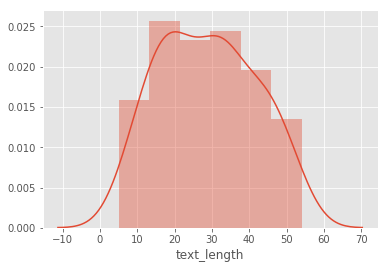

In [4]:
sns.distplot(df.text_length)

In [5]:
#Tokenize words

def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(df.full_text))


# Removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text]


d = enchant.Dict("en_US")

def remove_non_english_words(text):
    filtered_text = []

    for row in words:
        local_list = []
        for word in row:
            if d.check(word):
                if word != 'co':
                    local_list.append(word)

        filtered_text.append(local_list)

    return filtered_text
    
    
words = remove_stopwords(words)
words = remove_non_english_words(words)


# lemmatize words
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0 documents lemmatised


In [6]:
lemmatized_data = pd.Series(data_lemmatized).apply(lambda x: ' '.join(x))

In [7]:
lemmatized_data.head()

0    remember find guilty breach duty care punishment                                                                                 
1    pain time compromise cruel policy                                                                                                
2    well pay job start large average wage family man wanna start show release woman child amp family detention alp show true humanity
3    must read analysis policy paralysis asylum seeker pain time compromise cruel policy rat                                          
4    prosecutor general admit fight forcibly return mistake                                                                           
dtype: object

In [8]:
# Creating dictionary and the corpus for gensim's built-in LDA model

import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
 
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           per_word_topics=True)

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model= lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

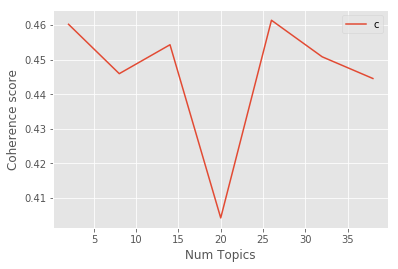

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Creating dictionary and the corpus for gensim's built-in LDA model

import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
 
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           per_word_topics=True)

In [19]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.208089 -0.011351  1       1        12.661789
7      0.077241 -0.123752  2       1        10.701693
8      0.048051  0.169731  3       1        9.960164 
0     -0.162814 -0.030030  4       1        9.372697 
4      0.097256 -0.127136  5       1        9.022395 
12     0.074259 -0.036744  6       1        7.930302 
6      0.060493  0.050012  7       1        7.659337 
10     0.088761  0.049472  8       1        6.224972 
5      0.034635  0.025386  9       1        5.372560 
1     -0.123402 -0.012722  10      1        5.191916 
9      0.046509 -0.029802  11      1        5.045983 
13     0.057959  0.040442  12      1        4.160323 
3      0.016581  0.018887  13      1        3.813689 
11    -0.107441  0.017609  14      1        2.882171 , topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
32    Default  15.000000  asylum         15.000000  30.0000  30.0000
336   Default  8.000000   restrictive    8.000000   29.0000  29.0000
339   Default  8.000000   school         8.000000   28.0000  28.0000
337   Default  8.000000   result         8.000000   27.0000  27.0000
340   Default  8.000000   star           8.000000   26.0000  26.0000
343   Default  8.000000   translate      8.000000   25.0000  25.0000
341   Default  8.000000   teach          8.000000   24.0000  24.0000
342   Default  8.000000   teen           8.000000   23.0000  23.0000
333   Default  8.000000   book           8.000000   22.0000  22.0000
335   Default  9.000000   receive        9.000000   21.0000  21.0000
55    Default  18.000000  refugee        18.000000  20.0000  20.0000
13    Default  15.000000  amp            15.000000  19.0000  19.0000
37    Default  12.000000  seeker         12.000000  18.0000  18.0000
338   Default  8.000000   scheme         8.000000   17.0000  17.0000
334   Default  10.000000  education      10.000000  16.0000  16.0000
169   Default  4.000000   today          4.000000   15.0000  15.0000
323   Default  4.000000   migration      4.000000   14.0000  14.0000
332   Default  3.000000   think          3.000000   13.0000  13.0000
441   Default  4.000000   say            4.000000   12.0000  12.0000
185   Default  3.000000   immigration    3.000000   11.0000  11.0000
359   Default  3.000000   migrant        3.000000   10.0000  10.0000
57    Default  5.000000   work           5.000000   9.0000   9.0000 
295   Default  3.000000   leave          3.000000   8.0000   8.0000 
301   Default  3.000000   wing           3.000000   7.0000   7.0000 
53    Default  5.000000   people         5.000000   6.0000   6.0000 
3     Default  3.000000   find           3.000000   5.0000   5.0000 
10    Default  9.000000   policy         9.000000   4.0000   4.0000 
135   Default  3.000000   last           3.000000   3.0000   3.0000 
161   Default  2.000000   country        2.000000   2.0000   2.0000 
325   Default  3.000000   abuse          3.000000   1.0000   1.0000 
323   Topic1   3.436295   migration      4.500113   1.7969  -3.7782 
406   Topic1   1.198708   specially      1.761893   1.6814  -4.8314 
235   Topic1   1.198708   content        1.761893   1.6814  -4.8314 
240   Topic1   1.198708   terror         1.761893   1.6814  -4.8314 
398   Topic1   1.198708   hut            1.761893   1.6814  -4.8314 
405   Topic1   1.198708   issue          1.761893   1.6814  -4.8314 
236   Topic1   1.198708   intelligence   1.761893   1.6814  -4.8314 
237   Topic1   1.198708   propaganda     1.761893   1.6814  -4.8314 
238   Topic1   1.198708   relate         1.761893   1.6814  -4.8314 
241   Topic1   1.198708   terrorism      1.761893   1.6814  -4.8314 
404   Topic1   1.198708   generally      1.761893   1.6814  -4.8314 
233   Topic1   1.198708   arrest         1.761893   1.6814  -4.8314 
234   Topic1   1.198707   aver           1.761893   1.681

In [20]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lemmatized_data)

In [21]:
pd.set_option('display.max_colwidth', 0)
df_topic_sents_keywords[:3]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,14,0.8839,"say, country, good, get, much, actually, somewhere, may, loathe, breach",remember find guilty breach duty care punishment
1,5,0.8452,"policy, cause, last, refugee, show, start, family, get, talk, cruel",pain time compromise cruel policy
2,8,0.6180,"refugee, asylum, policy, family, nurse, pay, woman, wage, child, show",well pay job start large average wage family man wanna start show release woman child amp family detention alp show true humanity


In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()


# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
 
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 

In [26]:
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9578,"asylum, seeker, refugee, star, education, school, book, teach, translate, scheme",congratulation wealthy refugee amp challenge choose lock people hopeless shore gulag different face comparatively huge flow adopt creative amp humane response
1,2,0.9536,"amp, immigration, concern, office, feel, federal, book, teen, teach, translate",give lip service concern welfare vulnerable amp disadvantaged perhaps homework amp report trend suicide amp death draconian amp policy
2,3,0.9381,"book, teen, teach, star, school, translate, result, receive, restrictive, education",teen teach translate school book receive star result restrictive asylum seeker education scheme hut
3,4,0.9536,"refugee, amp, seeker, today, allocate, process, entirety, gt, generous, cap",sec state announce refugee cap generous country world today allocate funding yr amp gt refugee seeker process entirety agree
4,5,0.9596,"policy, cause, last, refugee, show, start, family, get, talk, cruel",wrong ask cause rise last year answer immigration question mother problem correct would fake question cause reminder last year short fake news
5,6,0.9613,"amp, people, today, young, work, important, education, project, policy, public",today voice project amp next training talk film pm project start run want get involved refugee look find work medium someone help join
6,7,0.9680,"refugee, amp, garden, ask, kid, abuse, health, free, learning, different",really appreciate share young refugee amp student face complex personal challenge language barrier finance housing mental health past trauma make manage health engage education amp employment struggle homelessness
7,8,0.9578,"refugee, asylum, policy, family, nurse, pay, woman, wage, child, show",asylum seeker get lecture system war last check family business closing ground run mile claim asylum fact year already speak volume
8,9,0.9558,"leave, wing, amp, right, medical, child, everyone, madness, judge, agree",agree spin complete madness leave wing reasoning cult rape give short sentence female judge happen leave wing activist public outrage
9,10,0.9596,"refugee, address, poverty, election, asylum, year, work, seeker, last, problem",address poverty must address education need federal funding tackle massive problem many work citizen live borderline poverty tax refugee taxing finance liberal


# $$2.\ Sentiment\ Analysis\ with\ Vader$$

In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
analyzer = SentimentIntensityAnalyzer()

In [72]:
polarity_dic = {}

for i in range(len(lemmatized_data)):
    vader_sentiment = analyzer.polarity_scores(lemmatized_data[i]).items()
    sent_list = []
    for sentiment in vader_sentiment:
        sent_list.append(sentiment[1])
            
    polarity_dic[lemmatized_data[i]] = sent_list

In [96]:
lemmatized_data = lemmatized_data.drop_duplicates()

In [105]:
new_df = pd.DataFrame(lemmatized_data).rename(columns = {0:'filtered_text'}).join(pd.DataFrame(list(polarity_dic.values())).rename(columns = {0:'neg', 1:'neu',2:'pos', 3:'compound'}))



In [106]:
new_df

,filtered_text,neg,neu,pos,compound
0,remember find guilty breach duty care punishment,0.455,0.303,0.242,-0.4215
1,pain time compromise cruel policy,0.703,0.297,0.000,-0.7964
2,well pay job start large average wage family man wanna start show release woman child amp family detention alp show true humanity,0.146,0.672,0.183,0.2500
3,must read analysis policy paralysis asylum seeker pain time compromise cruel policy rat,0.392,0.608,0.000,-0.7964
4,prosecutor general admit fight forcibly return mistake,0.463,0.370,0.167,-0.4939
6,many fantastic nurse work people refugee background happy primary community health nurse week everyone,0.000,0.698,0.302,0.7579
7,free sensory garden workshop refugee background explore wellbe learning care different plant herb amp mini garden register,0.126,0.650,0.224,0.3400
8,tomorrow witness whose right safety right life jeopardy simply sexual orientation question support person home office need proof someone,0.099,0.423,0.479,0.8442
9,thank much drop round brilliant buggy hundred refugee family region come super handy,0.221,0.494,0.285,0.1779
10,reject plea bring child innocent people systematically deprive right amp dignity include medical treatment border security ideological malice,0.000,0.553,0.447,0.8271
